<a href="https://colab.research.google.com/github/hueyqing/LIN373_Project_SentimentAnalysis/blob/master/SentimentAnalysis_MovieReviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Sentiment Analysis of Text for Moview Review Prediction
Project by: Group 8, Tan Huey Qing [ ht7627 ] & Sarang Rastogi [ sr45936 ]<br><br>
__GOAL:__<br>
To be able to predict the sentiment of movie reviews as accurately as possible<br><br>
__WHAT IS SENTIMENT ANALYSIS?__<br>
Sentiment Analysis can be defined as the process of computationally determining whether a piece of writing is positive, negative, neutral etc. In context of speech it can be coined as ‘opinion mining’ to derive the opinion or attitude of a speaker. <br><br>
__DATA/ RESOURCES:__<br>
We have chosen the IMDB dataset of 50k movie reviews from here:<br>
https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews#IMDB%20Dataset.csv<br><br>
__MACHINE LEARNING ALGORITHMS/ MODELS:__<br>
To study the correlation between the sentiment analysis results and movie review sentiment prediction, we aim to implement algorithms of Naive Bayes, logistic Regression and SVMs depending on the trend the factor we choose displays and find the best model.<br><br>
__ACCURACY/ EVALUATION:__
We aim to find the accuracy of our sentiment analysis using k-fold cross validation and analysing the accuracy of predictions using multiple classifiers such as neural networks and ensemble methods. 

In [1]:
%%time
## load data
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# load data using sklearn.datasets.load_files
# dataset = load_files("IMDB_Dataset.csv")
df = pd.read_csv('IMDB_Dataset.csv')
df["review"] = df["review"].str.lower()
print(df.head())
#print(df['sentiment'].iloc[0])
for row in range (len(df)):
    if (df['sentiment'].iloc[row] == 'positive'):
        df['sentiment'].iloc[row] = 1
    else:
        df['sentiment'].iloc[row] = 0 

print (df.head())

                                              review sentiment
0  one of the other reviewers has mentioned that ...  positive
1  a wonderful little production. <br /><br />the...  positive
2  i thought this was a wonderful way to spend ti...  positive
3  basically there's a family where a little boy ...  negative
4  petter mattei's "love in the time of money" is...  positive
                                              review  sentiment
0  one of the other reviewers has mentioned that ...          1
1  a wonderful little production. <br /><br />the...          1
2  i thought this was a wonderful way to spend ti...          1
3  basically there's a family where a little boy ...          0
4  petter mattei's "love in the time of money" is...          1
Wall time: 1min 11s


In [2]:
# split the data into train and test

text_data = df.drop(['sentiment'], axis = 1)
print (text_data)
labels = df.drop(['review'], axis = 1)
print (labels)
docs_train, docs_test, y_train, y_test = train_test_split(text_data, labels, test_size = 0.2, random_state = 1000)
print (docs_train)

# vectorize the training data
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(docs_train.review)
print(len(vectorizer.get_feature_names()))
#print(vectorizer.get_feature_names()[:3000])
#print(X_train[0])

                                                  review
0      one of the other reviewers has mentioned that ...
1      a wonderful little production. <br /><br />the...
2      i thought this was a wonderful way to spend ti...
3      basically there's a family where a little boy ...
4      petter mattei's "love in the time of money" is...
...                                                  ...
49995  i thought this movie did a down right good job...
49996  bad plot, bad dialogue, bad acting, idiotic di...
49997  i am a catholic taught in parochial elementary...
49998  i'm going to have to disagree with the previou...
49999  no one expects the star trek movies to be high...

[50000 rows x 1 columns]
       sentiment
0              1
1              1
2              1
3              0
4              1
...          ...
49995          1
49996          0
49997          0
49998          0
49999          0

[50000 rows x 1 columns]
                                                  review
144

In [3]:
## create naive bayes model

from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# vectorize the test data and predict 
X_test = vectorizer.transform(docs_test.review)
y_hat_nb = nb_model.predict(X_test)

# get accuracy score
accuracy_score_nb = metrics.accuracy_score(y_test, y_hat_nb)

# print out some data
print("nb_model accuracy is : ", accuracy_score_nb)
print("classification report:\n", metrics.classification_report(y_test, y_hat_nb))


C:\Users\hueyq\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


nb_model accuracy is :  0.8415
classification report:
               precision    recall  f1-score   support

           0       0.82      0.87      0.85      5054
           1       0.86      0.81      0.83      4946

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [50]:
%%time
## create word2vec model

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

corpus_text = '\n'.join(df[:500]['review'])
sentences = corpus_text.split('\n')
sentences = [line.lower().split(' ') for line in sentences]

model = Word2Vec(sentences, size=100,  min_count=1) 
# change min count later
print(model)

# summarize vocabulary
words = list(model.wv.vocab)
print(words)

# to review embedded vector for a specific token:
# print(model.wv[<<INSERT TOKEN>>])

Word2Vec(vocab=20699, size=100, alpha=0.025)


['one', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching', 'just', '1', 'oz', 'episode', "you'll", 'be', 'hooked.', 'they', 'are', 'right,', 'as', 'this', 'is', 'exactly', 'what', 'happened', 'with', 'me.<br', '/><br', '/>the', 'first', 'thing', 'struck', 'me', 'about', 'was', 'its', 'brutality', 'and', 'unflinching', 'scenes', 'violence,', 'which', 'set', 'in', 'right', 'from', 'word', 'go.', 'trust', 'me,', 'not', 'a', 'show', 'for', 'faint', 'hearted', 'or', 'timid.', 'pulls', 'no', 'punches', 'regards', 'to', 'drugs,', 'sex', 'violence.', 'hardcore,', 'classic', 'use', 'word.<br', '/>it', 'called', 'nickname', 'given', 'oswald', 'maximum', 'security', 'state', 'penitentary.', 'it', 'focuses', 'mainly', 'on', 'emerald', 'city,', 'an', 'experimental', 'section', 'prison', 'where', 'all', 'cells', 'have', 'glass', 'fronts', 'face', 'inwards,', 'so', 'privacy', 'high', 'agenda.', 'em', 'city', 'home', 'many..aryans,', 'muslims,', 'gangstas,', 'latinos,'

Wall time: 1.08 s


In [51]:
# save word2vec model
# saved in a binary format to save space.

model.save('model.bin')

# load model
new_model = Word2Vec.load('model.bin')
print(new_model)

Word2Vec(vocab=20699, size=100, alpha=0.025)


C:\Users\hueyq\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\hueyq\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 151 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\hueyq\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 151 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\hueyq\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\hueyq\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:176: RuntimeWarning: Glyph 150 missing from current font.
  font.load_char(ord(s), flags=flags)
C:\Users\hueyq\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 133 missin

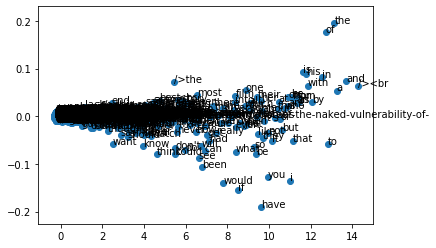

In [52]:
# plot word2vec model using PCA

from sklearn.decomposition import PCA
from matplotlib import pyplot

X = model[model.wv.vocab]

# fit a 2d PCA model to the vectors
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [58]:
# fun results with word2vec

word = "funny"
model.wv.most_similar(positive = word)

# this seems to be working wrongly......?????

[('but', 0.9999338984489441),
 ('about', 0.9999231696128845),
 ('not', 0.999922513961792),
 ('that', 0.9999217391014099),
 ('just', 0.9999215602874756),
 ('like', 0.9999213814735413),
 ('only', 0.9999208450317383),
 ('really', 0.9999206066131592),
 ('does', 0.9999202489852905),
 ('when', 0.9999201893806458)]